#Data Analysis
This notebooks contains some sample queries with output to showcase the use case of the capstone data infrastructure.

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

In [2]:
host = ""
dbname = "dev"
user = "awsuser"
password = ""
port = 5439

In [3]:
conn = psycopg2.connect(f"host={host} port={port} dbname={dbname} user={user} password={password}")
cur = conn.cursor()

In [63]:
schema_query = """
select n.nspname as table_schema,
       c.relname as table_name,
       c.reltuples as rows
from pg_class c
join pg_namespace n on n.oid = c.relnamespace
where c.relkind = 'r'
      and n.nspname not in ('information_schema','pg_catalog')
order by c.reltuples desc;
"""

In [64]:
cur.execute(schema_query)
cur.fetchall()

[('public', 'fact_event_attributes', 2231740.0),
 ('public', 'fact_events', 930624.0),
 ('public', 'staging_events', 930408.0),
 ('public', 'dim_players', 1055.0),
 ('public', 'staging_players', 1055.0),
 ('public', 'dim_matches', 243.0),
 ('public', 'staging_matches', 243.0),
 ('public', 'dim_type_attributes', 112.0),
 ('public', 'dim_types', 35.0),
 ('public', 'dim_teams', 31.0),
 ('pg_internal', 'redshift_auto_health_check_4298753', 0.001)]

## Average number of events & attributes per match


In [47]:
number_matches = """
SELECT 
count(match_id) 
FROM dim_matches;
"""

In [49]:
cur.execute(number_matches)
res_number_matches = cur.fetchone()
print(f"Number of matches: {res_number_matches[0]}")

Number of matches: 243


In [50]:
avg_events = """
SELECT avg(event_count) 
FROM (
	SELECT count(event.event_id) AS event_count
	FROM fact_events AS event
	GROUP BY match_id
)
"""

In [52]:
cur.execute(avg_events)
res_avg_events = cur.fetchone()
print(f"Average events per match: {res_avg_events[0]}")

Average events per match: 3829


In [54]:
avg_attributes = """
SELECT avg(attribute_count) 
FROM (
	SELECT count(event_attribute.event_attribute_id) AS attribute_count
	FROM fact_event_attributes AS event_attribute
	LEFT JOIN fact_events AS event
	ON event.event_id = event_attribute.event_id
	GROUP BY event.match_id
)
"""

In [56]:
cur.execute(avg_attributes)
res_avg_attributes = cur.fetchone()
print(f"Average attributes per match: {res_avg_attributes[0]}")

Average attributes per match: 9186


## Top 10 Goalscorers

In [57]:
topscorer_query = """
SELECT
count(event.event_id) as number_goals,
  player.player_name as player
FROM fact_events as event
LEFT JOIN dim_players AS player
ON event.player_id = player.player_id
LEFT JOIN fact_event_attributes AS attribute
ON event.event_id = attribute.event_id
WHERE attribute.attribute_name = 'shot.outcome.name'
AND attribute.attribute_value = 'Goal'
GROUP BY player
ORDER BY number_goals DESC
LIMIT 10
"""

In [58]:
cur.execute(topscorer_query)
cur.fetchall()

[(231, 'Lionel Andrés Messi Cuccittini'),
 (129, 'Luis Alberto Suárez Díaz'),
 (47, 'Neymar da Silva Santos Júnior'),
 (24, 'Ivan Rakitić'),
 (19, 'Antoine Griezmann'),
 (16, 'Ousmane Dembélé'),
 (13, 'Gerard Piqué Bernabéu'),
 (10, 'Jordi Alba Ramos'),
 (10, 'Philippe Coutinho Correia'),
 (9, 'Arturo Erasmo Vidal Pardo')]

# Average passes per game

In [7]:
avg_pass = """
select avg(pass_count) 
from (
	select count(event.event_id) as pass_count
	from fact_events as event
	left join dim_types as type
	on event.type_id = type.type_id
	where type.type_name = 'Pass'
	group by match_id
)
"""


In [59]:
cur.execute(avg_pass)
res_avg_passes = cur.fetchone()
print(f"Average passes per match: {res_avg_passes[0]}")

Average passes per match: 1074


## Dribbling score and avg successfull dribblings

In [60]:
dribbling = """
SELECT round(avg(cast(dribble_count AS FLOAT)), 2), dribbling, player_name FROM (
	SELECT count(event_attribute_id) AS dribble_count, player.dribbling, player.player_name
	FROM fact_event_attributes AS attribute
	LEFT JOIN fact_events AS event
	ON event.event_id = attribute.event_id
	LEFT JOIN dim_players AS player
	ON player.player_id = event.player_id
	WHERE attribute_name = 'dribble.outcome.name' 
	AND attribute_value='Complete'
	AND player.team_id = 217
	
	GROUP BY event.match_id, player.player_name, player.dribbling
)
GROUP BY player_name, dribbling
"""

In [61]:
cur.execute(dribbling)
res_dribbling = cur.fetchall()
dribbling_df = pd.DataFrame(res_dribbling)

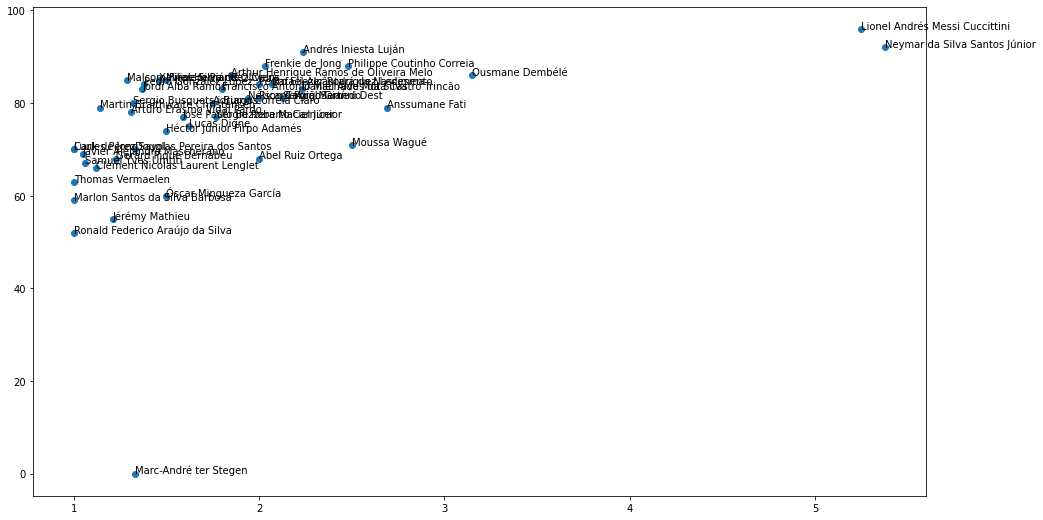

In [62]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(dribbling_df[0], dribbling_df[1])

for i, txt in enumerate(dribbling_df[2]):
    ax.annotate(txt, (dribbling_df[0][i], dribbling_df[1][i]))

In [57]:
conn.close()